## Course: TM10007 - Machine learning
Editors: Lishia Vergeer, Amy Roos, Maaike Pruijt, Hilde Roording.

Description: The aim of this code is to predict the tumor grade of glioma’s (high or low), 
based on features extracted from a combination of four MRI images: 
T2-weighted, T2-weighted FLAIR and T1-weighted before and after injection of contrast agent.

#### Import packages

In [92]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Import code
from brats.load_data import load_data

# Split
from sklearn.model_selection import train_test_split

# scaler
from sklearn.preprocessing import MinMaxScaler 

# gridsearch
from sklearn.model_selection import RandomizedSearchCV

#Machine learning classifiers
from sklearn import decomposition, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

#### Load data
In nthe section below the data is loaded with given function load_data.py by creating a dataframe from de CSV file called data_brats.csv. The number of samples and features is printed below.

In [93]:
data_brats = load_data()

# Convert to dataframe
X = pd.DataFrame(data_brats)

# Print data 
print(f'The number of samples in data_brats: {len(X.index)}')
print(f'The number of columns in data_brats: {len(X.columns)}')

The number of samples in data_brats: 167
The number of columns in data_brats: 725


#### Split data in X (data) and y (label)
The data contains the columns with features as well as a column with the label that needs to be predicted (GBM or LGG). In this section this label is splitted from the dataframe in X (data) and y (label). Also the textual labels are converted to binary numbers to be easily processed.

In [94]:
# split column label from dataset X
y = X.pop('label')

# replace 'GBM' and 'LGG' with 1 and 0 respectively
y = y.replace(['GBM'], 1)
y = y.replace(['LGG'], 0)

#### Split data in train and test set
This section splits the data into two data frames, a test and a train data frame with the train_test_split function from the sklearn module.
This returns a train set with the data of 80% and a test set of 20% of the subjects.

In [95]:
# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)  

#### Divergent values to NaN
In this section non-numeric values as 'infinity' and '#DIV/0' values in both the test and train data frames are replaced by 'NaN' values.

In [96]:
# infinity to NaN
X_train[X_train==np.inf]=np.nan
X_test[X_test==np.inf]=np.nan

# non-numeric features to NaN
X_train = X_train.replace(['#DIV/0!'], np.nan)
X_train = X_train.apply(pd.to_numeric, errors='coerce')

X_test  = X_test.replace(['#DIV/0!'], np.nan)
X_test = X_test.apply(pd.to_numeric, errors='coerce')

#### Visualize missing data
In this section below the missing values of the training data frame are visualized.

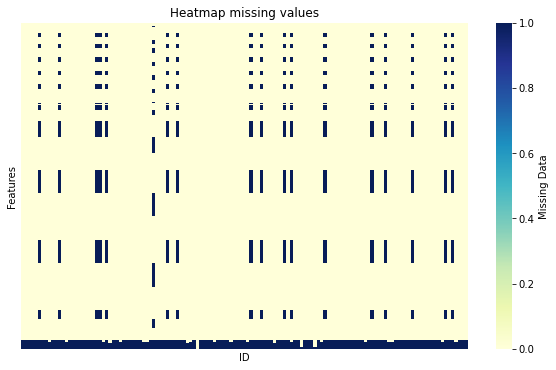

In [97]:
plt.figure(figsize=(10,6))
sb.heatmap(X_train.isna().transpose(),
            yticklabels=False, xticklabels=False, 
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)
plt.title('Heatmap missing values')
plt.ylabel('Features')
plt.xlabel('ID')
plt.savefig("visualizing_missing_data_with_heatmap.png", dpi=100)

#### Set outliers to NaN
In the section below the outliers of the train data frame are converted to 'NaN' values. Below the amount of outliers is visualized in a table and a histogram.



C:\Users\amymy\miniconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,0
count,724.000000
mean,5.593593
std,5.260102
min,0.000000
25%,1.515152
50%,3.787879
75%,8.620690
max,33.333333


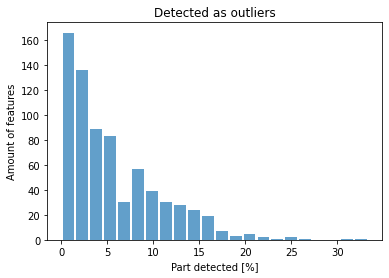

In [98]:
count_outs = []
count_percent = []
for column in X_train:
    # Removing outliers
    q1 = X_train[column].quantile(0.25)
    q3 = X_train[column].quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Information outliers
    outliers = [x for x in X_train[column] if x < lower or x > upper]
    outliers_removed = [x for x in X_train[column] if x >= lower and x <= upper]
    count_out = float(len(outliers))
    count_rem = float(len(outliers_removed))
    count_outs.append(count_out)

    if not count_out and not count_rem:
        percent = 0    
    else:
        percent = count_out/(count_out+count_rem)*100
    count_percent.append(percent)

    # Outliers to NaN
    X_train[column].loc[X_train[column] > upper] = np.nan
    X_train[column].loc[X_train[column] < lower] = np.nan

# percent
plt.figure
plt.hist(x=count_percent, bins='auto', alpha=0.7, rwidth=0.85)
plt.title('Detected as outliers')
plt.xlabel('Part detected [%]')
plt.ylabel('Amount of features')
plt.savefig("Removed.png", dpi=100)
df_describe = pd.DataFrame(count_percent)
df_describe.describe()

#### Visualising missing data after removing outliers
In the section below the training data frame is visualized after the removal of outliers.

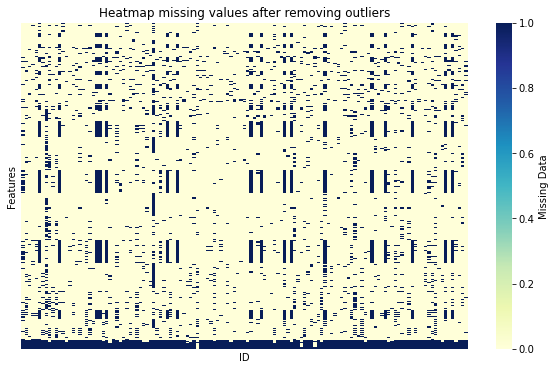

In [99]:
plt.figure(figsize=(10,6))
sb.heatmap(X_train.isna().transpose(),
            yticklabels=False, xticklabels=False, 
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)
plt.title('Heatmap missing values after removing outliers')
plt.ylabel('Features')
plt.xlabel('ID')
plt.savefig("visualizing_missing_data_with_heatmap_outliers.png", dpi=100)

#### Drop insufficient columnns (features)
In the section below all features that contain more than 40% NaN values in de train data frame are dropped from the data frame. The same features are also dropped from the test data frame.

In [100]:
# If the total number of NaN observations in a column are greater than 40%, delete the entire column.
perc = 40.0
min_count = int(((100-perc)/100)*X_train.shape[0] + 1)
X_train_drop = X_train.dropna(axis=1, thresh=min_count)
X_labels = X_train_drop.keys()

X_test_drop = X_test[X_labels]

#### Fill the NaN values.

In the section below all remaining NaN values are replaced by the mean of the values from the corresponding feature.


In [101]:
data_fill_train = X_train_drop.fillna(X_train_drop.mean()) 
data_fill_test = X_test_drop.fillna(X_test_drop.mean()) 

#### Scale features
In the section below the train data as well as the test data is normalized by the use of the MinMaxScaler().

In [102]:
# Scaler
scaler = MinMaxScaler()
scaler.fit(data_fill_train)
X_train_scaled = scaler.transform(data_fill_train)
X_test_scaled = scaler.transform(data_fill_test)

#### Transform features
To create a dataframe with usefull features to train the classifier, a principe component analysis (PCA) is performed.

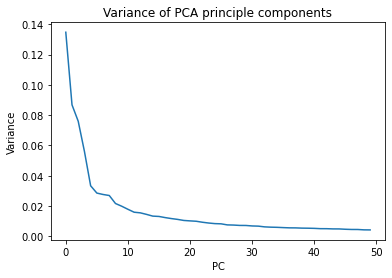

In [103]:
# Visualisation PCA components variance
pca_visual = decomposition.PCA(n_components=50)
pca_visual.fit(X_train_scaled) 
explained_variance = pca_visual.explained_variance_ratio_
plt.plot(explained_variance)
plt.title('Variance of PCA principle components')
plt.xlabel('PC')
plt.ylabel('Variance')
plt.savefig("Variance.png", dpi=100)

# Perform PCA
pca = decomposition.PCA(n_components=10)
pca.fit(X_train_scaled) 
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#### Cross validation
In the section below the cross validation score (specifically the ROC AUC) of three classifiers is calculated, based on which the best classifier can be selected for the data.

In [104]:
# Create a cross-validation object
cv = KFold(n_splits=5, shuffle= True, random_state = 1)

X = X_train_pca

y = y_train.values
y = y.tolist()

classifiers = (KNeighborsClassifier(), RandomForestClassifier(), SVC())

score_list = []
for cls in classifiers:
    rocauc = cross_val_score(cls, X, y, scoring = 'roc_auc', cv = cv)
    mean = np.mean(rocauc)
    score_list.append(mean)

df = pd.DataFrame(score_list, index =['KNN', 'RF', 'SVM'], columns =['mean ROC AUC'])

print(df)

     mean ROC AUC
KNN      0.894046
RF       0.932057
SVM      0.916203


#### Support Vector Machine hyper parameter search 
In the section below the optimal settings for the selected classifier (SVM) are calculated.


In [128]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma' : [1, 0.1, 0.01, 0.001],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}

svm_model = SVC(gamma='auto')

svm_grid = RandomizedSearchCV(estimator = svm_model, param_distributions = param_grid, cv = 5, verbose = 2, n_jobs =4)
svm_grid.fit(X_train_pca, y_train)

best_estimator = svm_grid.best_estimator_

print(f'The best estimators are : {best_estimator}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best estimators are : SVC(C=10, gamma=0.01, kernel='linear')


#### Performance SVM
In the section below the performance of the SVM classifier used for the test set is calculated.

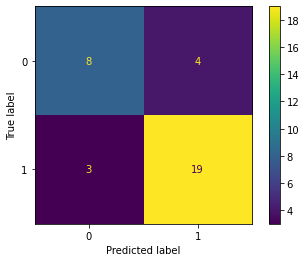

                accuracy  sensitivity  specificity        F1
SVM classifier  0.794118     0.863636     0.666667  0.794118
Test accuracy train set is:0.917


In [130]:
pred = svm_grid.predict(X_test_pca)
metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

classifier = 'SVM'
accuracy = metrics.accuracy_score(y_test, pred)
sensitivity = metrics.recall_score(y_test, pred, pos_label=1)
specificity = metrics.recall_score(y_test, pred, pos_label=0)
F1 = metrics.f1_score(y_test, pred, average='micro')

dict_test = {'accuracy': [accuracy], 'sensitivity': [sensitivity], 'specificity': [specificity], 'F1': [F1]}
performance = pd.DataFrame(dict_test, index = ['SVM classifier'])

print(performance)
print(f'Test accuracy train set is:{svm_grid.score(X_train_pca, y_train):.3f}')